# Retenção de profissionais de saúde

O presente código tem como objetivo gerar gráficos para as análises descritivas de retenção de profissionais médicos.  

## Leitura de bibliotecas necessárias para as análises

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from descartes import PolygonPatch
from sklearn.linear_model import LinearRegression

Leitura dos dados necessários para análise

In [6]:
df = pd.read_csv(r"C:\Users\Lapei_Cigets\Documents\GitHub\retencao\0_dados\Médico_retencao_geral.csv",sep=";")
df = df[['regiao_saude','retencao_geral']]

df.head()

,regiao_saude,retencao_geral
0,27010,0.435182
1,27007,0.541969
2,27004,0.331931
3,27001,0.773167
4,27005,0.393377


In [7]:
hierarquia = pd.read_csv(r"C:\Users\Lapei_Cigets\Documents\GitHub\retencao\0_dados\hierarquia_atualizada.csv")

reg_saude = hierarquia[['regiao',
                        'uf_sigla',
                        'cod_regsaud',
                        'regiao_saude_pad']].drop_duplicates().reset_index(drop=True)
reg_saude

,regiao,uf_sigla,cod_regsaud,regiao_saude_pad
0,Região Norte,RO,11001,VALE DO JAMARI
1,Região Norte,RO,11003,CENTRAL
2,Região Norte,RO,11004,MADEIRA-MAMORE
3,Região Norte,RO,11005,ZONA DA MATA
4,Região Norte,AC,12001,ALTO ACRE
...,...,...,...,...
445,Região Norte,AM,13003,RIO MADEIRA
446,Região Norte,AP,16002,AREA NORTE
447,Região Sudeste,SP,35016,SAO PAULO
448,Região Sudeste,MG,31011,TRES PONTAS


In [8]:
# juntando dados para identificar a região de saúde, a unidade da federação e a região do país
df = df.merge(reg_saude, 
         how = 'left',
         left_on = 'regiao_saude',
         right_on= 'cod_regsaud')

df['regiao'] = df['regiao'].str.replace('Região','').str.strip()


## Gerando gráficos 

Primeiro vamos gerar um gráfico de boxplot por região. Percebe-se que a mediana das regiões Sul e Sudeste são as mais elevadas. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


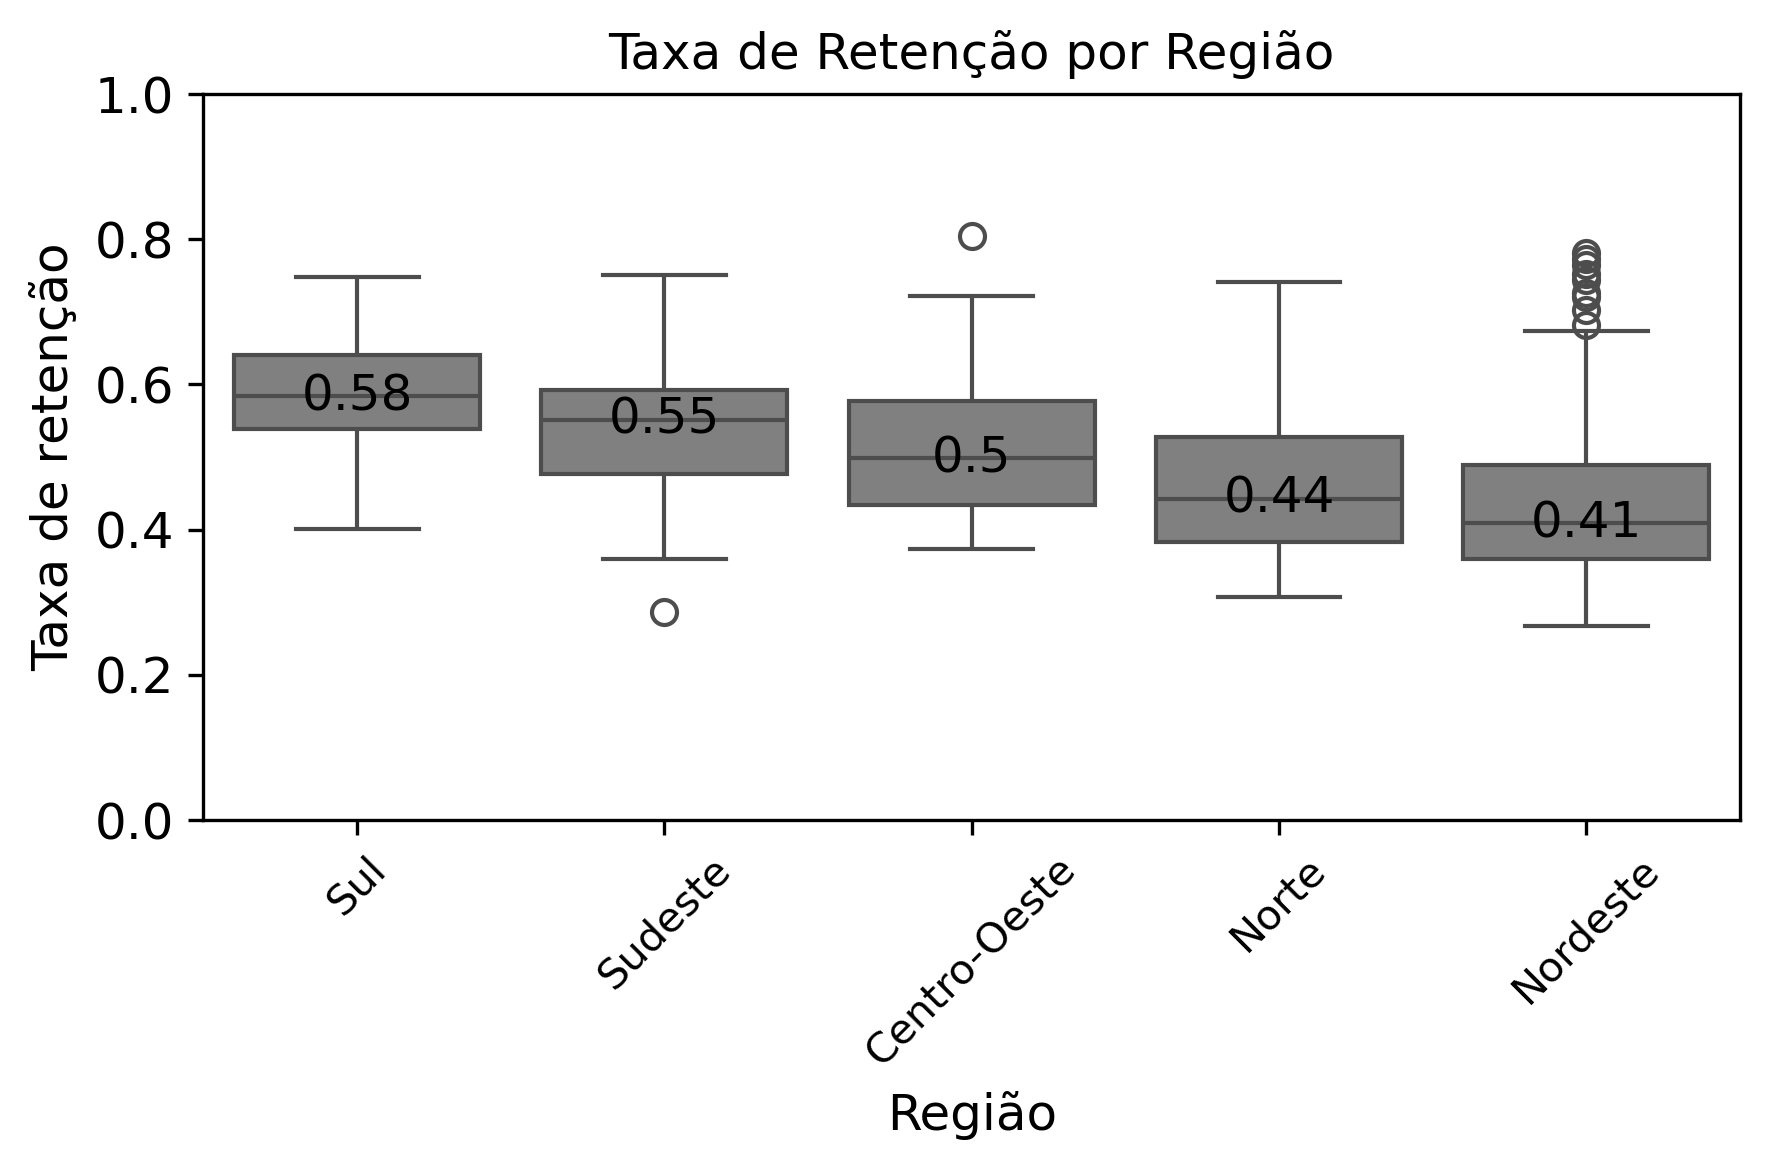

In [9]:


# Criando o gráfico
plt.figure(figsize=(6,4), dpi=300)
sns.boxplot(data=df, 
            x='regiao', 
            y='retencao_geral', 
            order=df.groupby('regiao')['retencao_geral'].median().sort_values(ascending=False).index,
            color="gray")

# customizando elementos do gráfico

plt.ylim(0, 1)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=12)
plt.xlabel("Região", fontsize=12)
plt.ylabel("Taxa de retenção", fontsize=12)
plt.title("Taxa de Retenção por Região", fontsize=12)
plt.tight_layout()

# calculando medianas para inserir valores no gráfico
medianas_regiao = df.groupby('regiao')['retencao_geral'].median().reset_index()
medianas_regiao = medianas_regiao.rename(columns={'retencao_geral': 'mediana'})

# Adicionando as medianas ao gráfico na posição correta

ordered_regions = df.groupby('regiao')['retencao_geral'].median().sort_values(ascending=False).index

for _, row in medianas_regiao.iterrows():
    x_position = list(ordered_regions).index(row['regiao'])  # Garantindo que a posição no eixo x esteja correta
    plt.text(x=x_position, y=row['mediana'], s=round(row['mediana'], 2), 
             ha='center', va='center', color='black', size=12)

plt.legend().set_visible(False)

plt.show()


O boxplot para unidades da federação ratificam os resultados anteriores. 

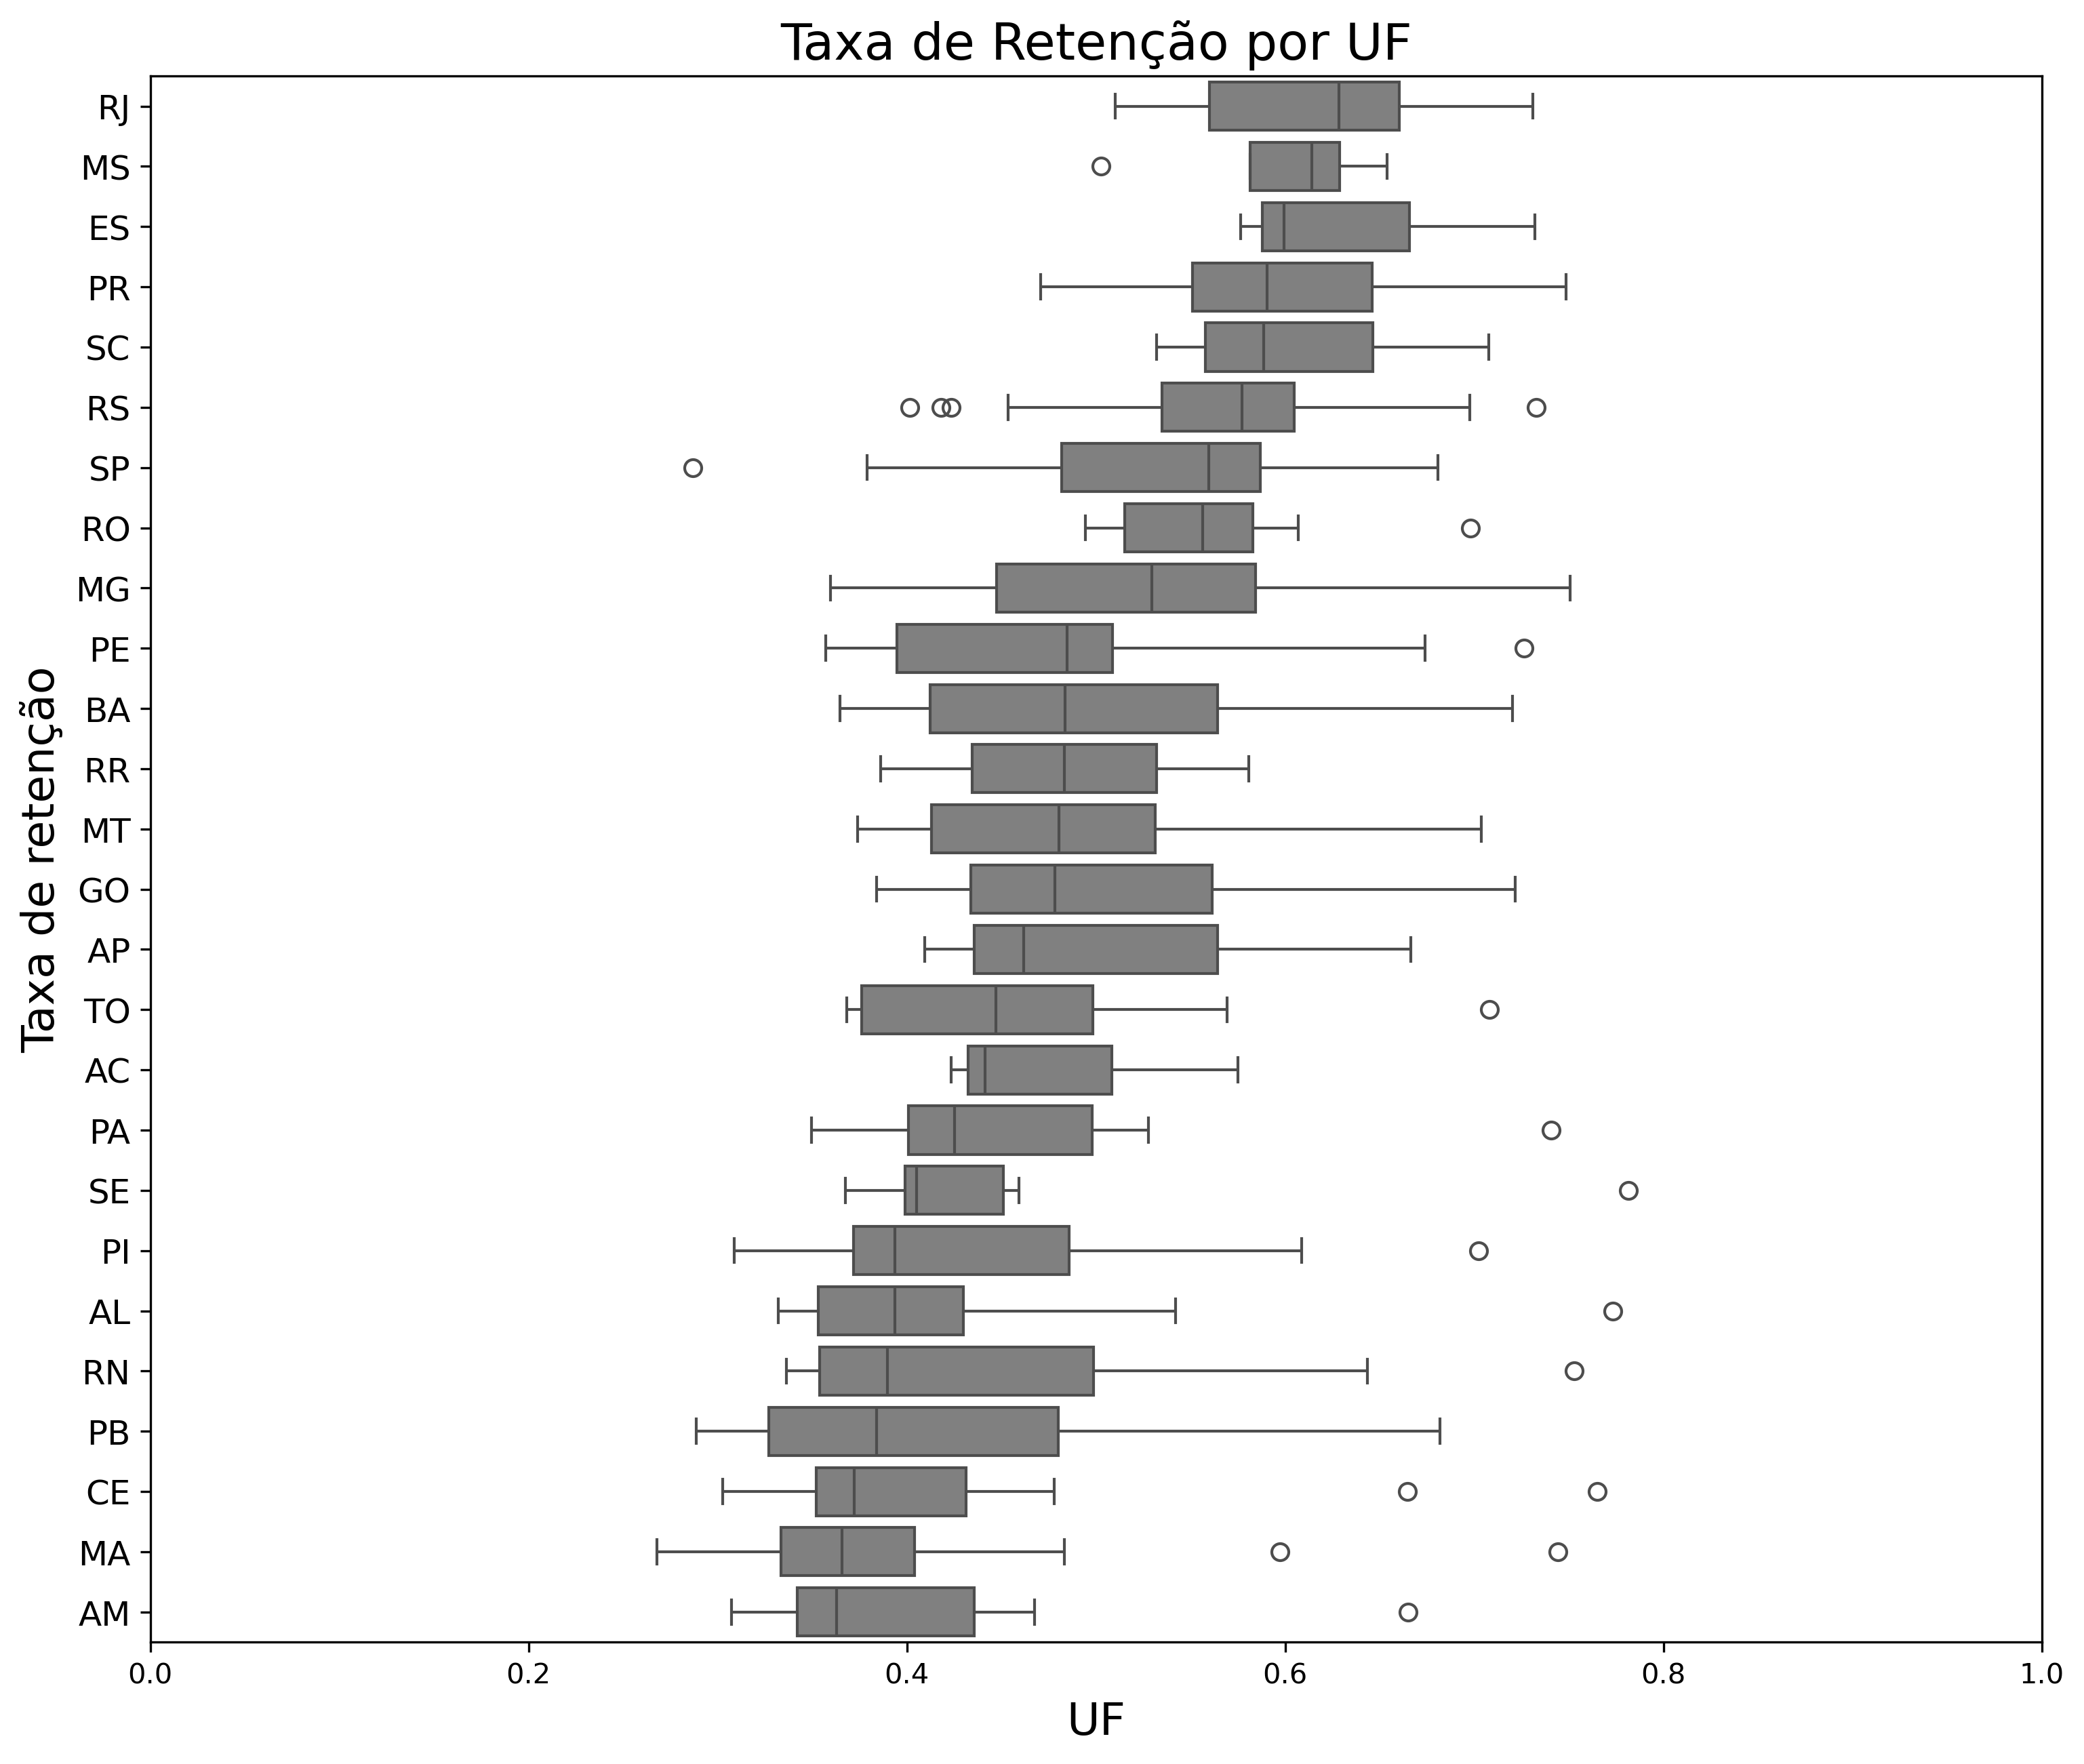

In [10]:
# retirando DF, pois não tem divisão por região de saúde na UF
df_sem_df = df[df['uf_sigla'] != 'DF']


plt.figure(figsize=(12, 10), dpi=300)
sns.boxplot(data=df_sem_df, 
            x='retencao_geral', 
            y='uf_sigla', 
            order=df_sem_df.groupby('uf_sigla')['retencao_geral'].median().sort_values(ascending=False).index,
            color="gray")

plt.xlim(0, 1)
plt.yticks(fontsize=12)
plt.xlabel("UF", fontsize=16)
plt.ylabel("Taxa de retenção", fontsize=16)
plt.title("Taxa de Retenção por UF", fontsize=18)

plt.show()

Retenção versus Densidade de Médicas por Populacional

In [11]:
razao_medicos = pd.read_excel(r"C:\Users\Lapei_Cigets\Documents\GitHub\retencao\0_dados\razao_medicos.xlsx")
razao_medicos.head()

,UF,cod_uf,Razão
0,DF,53,5.53
1,RJ,33,3.77
2,SP,35,3.50
3,SC,42,3.05
4,RS,43,3.04


In [12]:
medianas_uf = df.groupby(['uf_sigla','regiao'])['retencao_geral'].median().reset_index()

razao_retencao = razao_medicos.merge(medianas_uf, 
                                        how = 'left',
                                        left_on = 'UF',
                                        right_on = 'uf_sigla')

# retirando o DF
tbl_uf = razao_retencao[(razao_retencao['UF'] != 'DF')]
tbl_uf = tbl_uf.reset_index(drop=True)
tbl_uf

,UF,cod_uf,Razão,uf_sigla,regiao,retencao_geral
0,RJ,33,3.77,RJ,Sudeste,0.628357
1,SP,35,3.50,SP,Sudeste,0.559472
2,SC,42,3.05,SC,Sul,0.588644
3,RS,43,3.04,RS,Sul,0.577171
4,ES,32,3.00,ES,Sudeste,0.599456
5,MG,31,2.91,MG,Sudeste,0.529651
6,PB,25,2.81,PB,Nordeste,0.383871
7,PR,41,2.80,PR,Sul,0.590502
8,MS,50,2.67,MS,Centro-Oeste,0.613962
9,GO,52,2.64,GO,Centro-Oeste,0.478192


Fazendo um gráfico de retenção versus razão de médicos

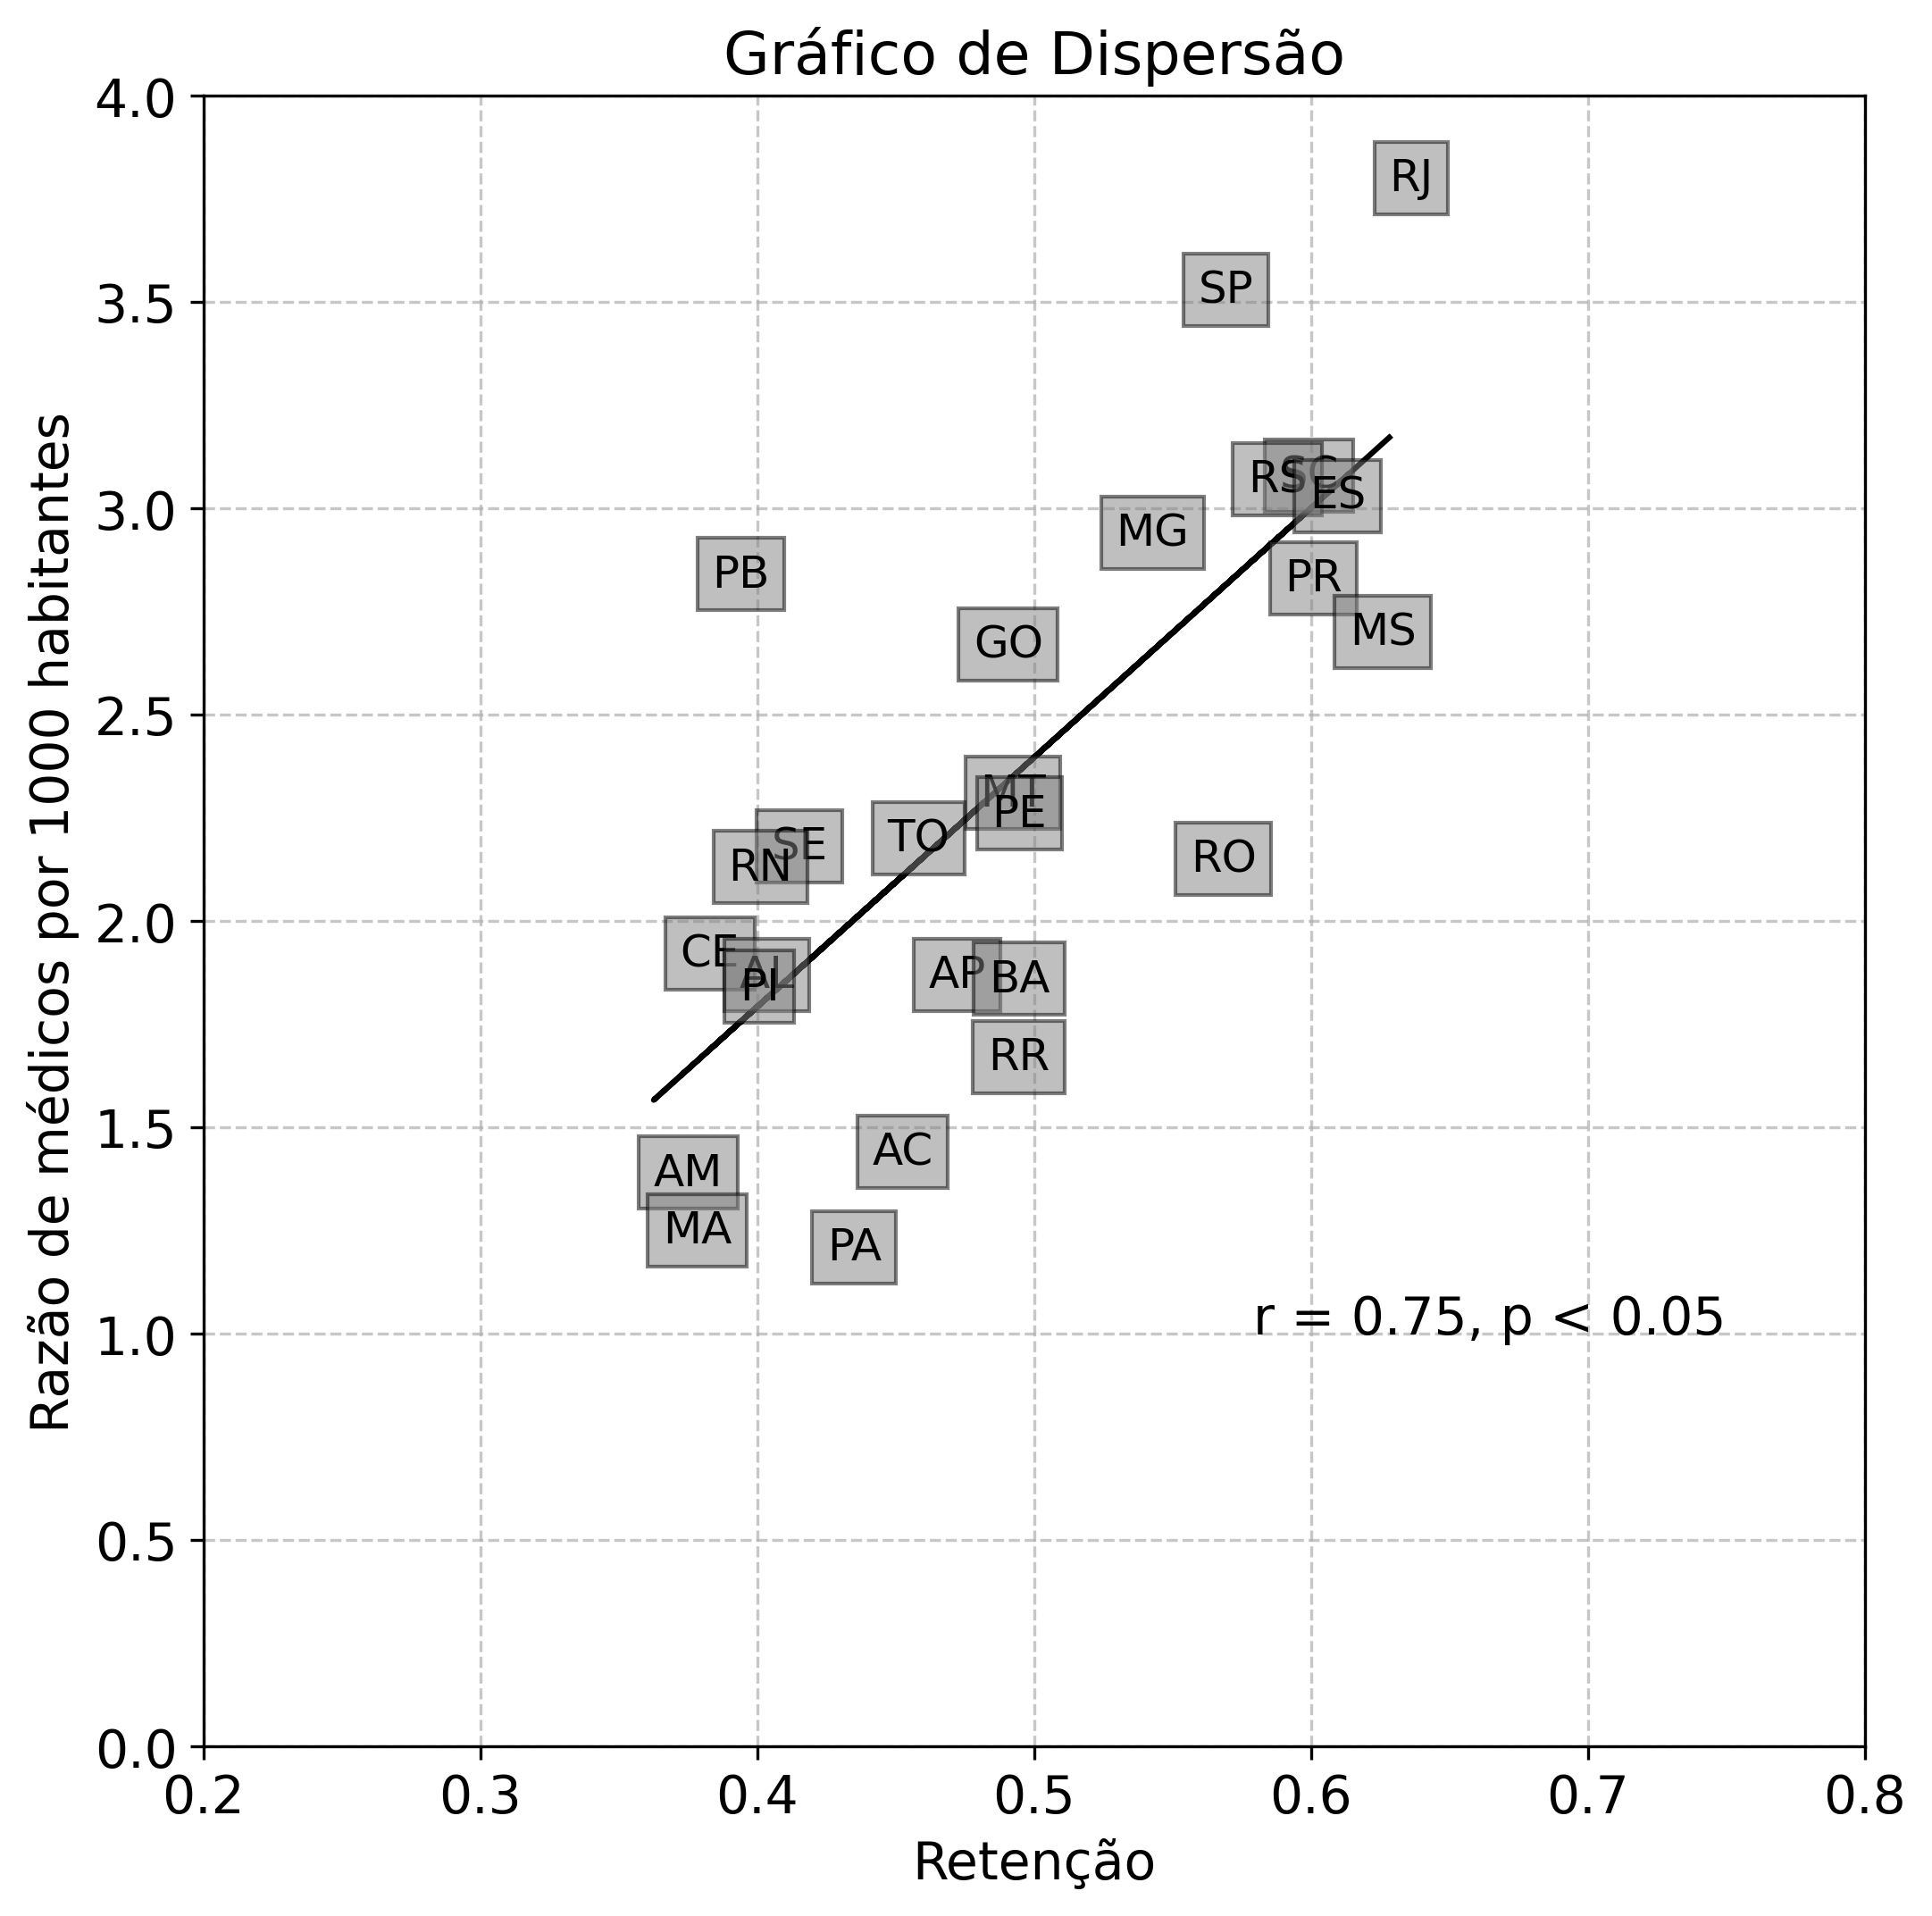

In [15]:
plt.figure(figsize=(8, 8),
           dpi = 300)

for i in range(tbl_uf.shape[0]):
    plt.text(x=tbl_uf['retencao_geral'][i], 
             y=tbl_uf['Razão'][i], 
             s=tbl_uf['UF'][i], 
             fontdict=dict(color='black', size=12), 
             bbox=dict(facecolor='gray', alpha=0.5))

# Adicionando a linha de tendência 
X = tbl_uf['retencao_geral'].values.reshape(-1, 1)
y = tbl_uf['Razão'].values
reg = LinearRegression().fit(X, y)
plt.plot(tbl_uf['retencao_geral'], reg.predict(X), 
         color='black')

# Ajustes no tema
plt.xlabel('Retenção', fontsize=14)
plt.ylabel('Razão de médicos por 1000 habitantes', fontsize=14)
plt.xlim(0.2, 0.8)
plt.ylim(0, 4)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Gráfico de Dispersão', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)

# Adicionando texto anotado
r = np.corrcoef(tbl_uf['retencao_geral'], tbl_uf['Razão'])[0, 1]
p_text = 'p < 0.05'  # Exemplo; substitua pelo valor real de p se disponível
plt.text(0.75, 1, f'r = {round(r, 2)}, {p_text}', fontsize=14, ha='right')

# Mostrando o gráfico
plt.show()


Vamos criar um mapa para representar a retenção de profissionais médicos. 

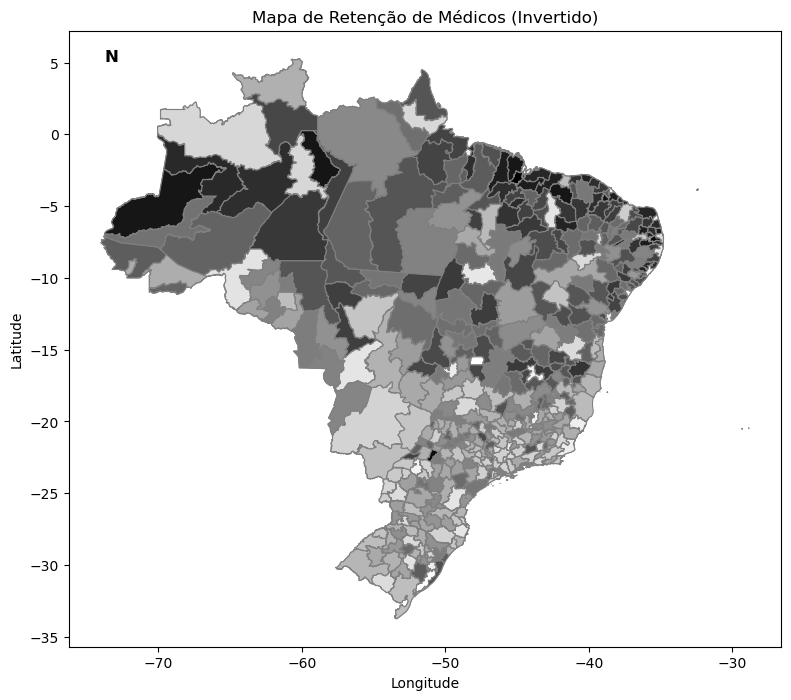

In [17]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Assuming your GeoJSON file path and DataFrame (`df`) are correct
spdf = gpd.read_file(r"C:\Users\Lapei_Cigets\Documents\GitHub\retencao\1_scripts\shape file regioes saude.json")
spdf['reg_id'] = spdf['reg_id'].astype(int)

mapa = spdf.merge(df, how='left', left_on='reg_id', right_on='cod_regsaud')
mapa = gpd.GeoDataFrame(mapa, geometry='geometry')

fig, ax = plt.subplots(figsize=(12, 8))

# Create an inverted grayscale colormap using `reversed()`
cmap = plt.cm.Greys_r  # Inverted grayscale
mapa.plot(column='retencao_geral', cmap=cmap, linewidth=0.8, ax=ax, edgecolor='0.5')

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Mapa de Retenção de Médicos (Invertido)')  # Indicate inversion in title

# Add north arrow (assuming coordinates are in geographic projection)
north_arrow_x, north_arrow_y = 0.05, 0.95  # Adjust coordinates as needed
arrow_size = 0.02  # Adjust size as needed
ax.annotate('', xy=(north_arrow_x, north_arrow_y), xytext=(north_arrow_x + arrow_size, north_arrow_y),
             arrowprops=dict(facecolor='black', shrink=0.05))
ax.text(north_arrow_x, north_arrow_y + 0.02, 'N', transform=ax.transAxes, va='top', ha='left', fontsize=12, fontweight='bold')

plt.show()